In [66]:
from keras.datasets import boston_housing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

from keras import models
from keras import layers

from keras.callbacks import ModelCheckpoint, EarlyStopping

Loading dataset & Check dataset

In [67]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print('shape of train data : ', train_data.shape)
print('shape of test data : ', test_data.shape)
print('number of features : ', len(train_data[0]))
print('examples of label : ',train_targets[:5])

shape of train data :  (404, 13)
shape of test data :  (102, 13)
number of features :  13
examples of label :  [15.2 42.3 50.  21.1 17.7]


Prepare the data (Normalization)

- 각 열에 대해 평균, 표준편차를 구해 변수별로 값을 정규화시킨다. 이 때 주의해야 될 점은 모델 평가를 할 때 test data에 대해 어떠한 정보도 모른다는 가정 하에 진행해야 하기 때문에, 훈련 데이터에서 구한 평균, 표준편차를 이용하여 정규화시킨다.

In [68]:
print(train_data[0])

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# 0-1사이로 normalization되었는지 확인
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


In [70]:
def graph(num_epochs):
    
    plt.clf() 
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
    plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

    smooth_mae_history = smooth_curve(average_mae_history[10:])

    plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()
        

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


## 0-1. Baseline
- Hidden layer : 2
- Hidden units : 64-64-1
- Optimizer : rmsprop
- Loss : mse
- Metrics : mae
- Activation : relu
- Learning rate : 0.001
- Epochs : 100
- Batch_size : 1
- K-fold validation : 4

#### Result >  Test mae: 2.646430730819702

In [ ]:
all_mae_histories = []
epochs = 100
batch_size = 1

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model


num_val_samples = len(train_data) // 4
all_scores = []

cp = ModelCheckpoint(filepath='./check.h5',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

for i in range(4):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), callbacks=[cp], epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

validation_mae = np.mean(all_mae_histories)
validation_mae

Validation mae: 2.452393695414066


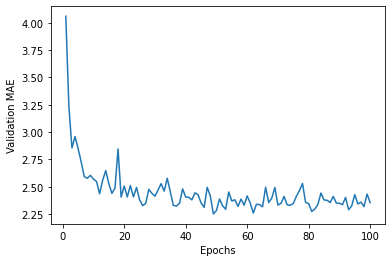

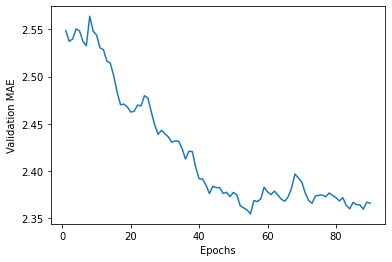

4/4 [==============================] - 0s 3ms/step - loss: 16.6184 - mae: 2.6464

 Test mae: 2.646430730819702


In [101]:
print('Validation mae:', validation_mae)

graph(epochs)

# test dataset
model.load_weights('./check.h5')
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('\n','Test mae:', test_mae_score)

## 0-2. Change epochs
- Hidden layer : 2
- Hidden units : 64-64-1
- Optimizer : rmsprop
- Loss : mse
- Metrics : mae
- Activation : relu
- Learning rate : 0.001
- Epochs : ***500***
- Batch_size : 1
- K-fold validation : 4

#### Result >  Test mae: 2.8308022022247314

In [ ]:
all_mae_histories = []
num_epochs = 500
batch_size = 1

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model


num_val_samples = len(train_data) // 4
all_scores = []

cp = ModelCheckpoint(filepath='./check.h5',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

for i in range(4):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), callbacks=[cp], epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

validation_mae = np.mean(all_mae_histories)
validation_mae

Validation mae: 2.4423563023209574


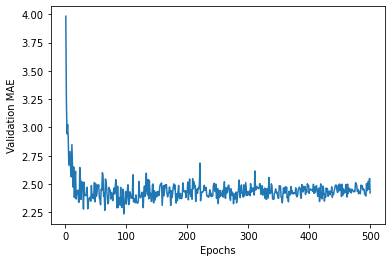

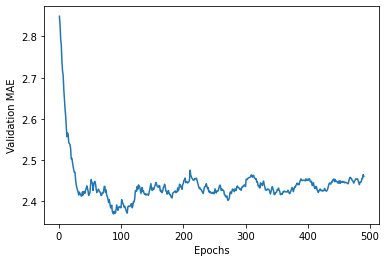

4/4 [==============================] - 0s 3ms/step - loss: 16.5432 - mae: 2.8308

 Test mae: 2.8308022022247314


In [105]:
print('Validation mae:', validation_mae)

graph(num_epochs)

# test dataset
model.load_weights('./check.h5')
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('\n','Test mae:', test_mae_score)

## 1. Change Hidden units
- Hidden layer : ***5***
- Hidden units : ***64-64-64-64-64-1***
- Optimizer : rmsprop
- Loss : mse
- Metrics : mae
- Activation : relu
- Learning rate : 0.001
- Epochs : ***100***
- Batch_size : ***20***
- K-fold validation : 4

#### Result >   Test mae: 2.588343620300293

In [ ]:
all_mae_histories = []
epochs = 100
batch_size = 20

def build_model():
    model1 = models.Sequential()
    model1.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dense(1))
    model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model1

validation_mae = k_fold(4, epochs, batch_size)


Validation mae: 3.0776976132392884


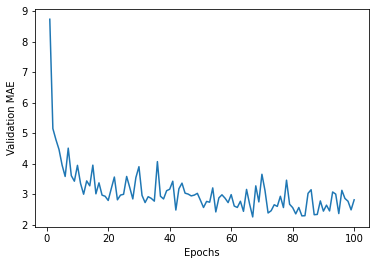

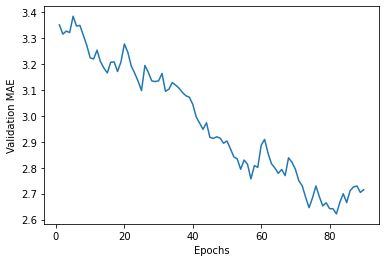

4/4 [==============================] - 0s 3ms/step - loss: 18.1560 - mae: 2.5883

 Test mae: 2.588343620300293


In [84]:
print('Validation mae:', validation_mae)

graph(epochs)

# test dataset
# model.load_weights('./check.h5')
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('\n','Test mae:', test_mae_score)

## 2. Change Hidden units
- Hidden layer : 2
- Hidden units : ***128-64-1***
- Optimizer : rmsprop
- Loss : mse
- Metrics : mae
- Activation : relu
- Learning rate : 0.001
- Epochs : ***100***
- Batch_size : ***20***
- K-fold validation : 4

####Result >  Test mae: 2.7715373039245605

In [ ]:
all_mae_histories = []
num_epochs = 100
batch_size = 20

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


num_val_samples = len(train_data) // 4
all_scores = []

cp = ModelCheckpoint(filepath='./check.h5',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

for i in range(4):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), callbacks=[cp], epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

validation_mae = np.mean(all_mae_histories)
validation_mae

Validation mae: 2.942691235542297


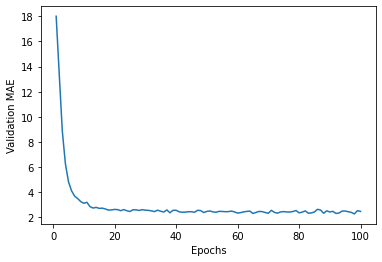

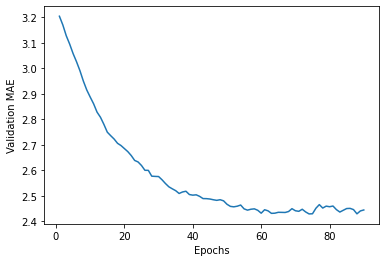

4/4 [==============================] - 0s 3ms/step - loss: 20.2125 - mae: 2.7715

 Test mae: 2.7715373039245605


In [95]:
print('Validation mae:', validation_mae)

graph(epochs)

# test dataset
model.load_weights('./check.h5')
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('\n','Test mae:', test_mae_score)

## 3. Change Activation function
- Hidden layer : 2
- Hidden units : 64-64-1
- Optimizer : rmsprop
- Loss : mse
- Metrics : mae
- Activation : ***tanh***
- Learning rate : 0.001
- Epochs : ***100***
- Batch_size : ***20***
- K-fold validation : 4

####Result >   Test mae: 2.529146194458008

In [ ]:
all_mae_histories = []
num_epochs = 100
batch_size = 20

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='tanh', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='tanh'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


num_val_samples = len(train_data) // 4
all_scores = []

cp = ModelCheckpoint(filepath='./check.h5',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

for i in range(4):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), callbacks=[cp], epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

validation_mae = np.mean(all_mae_histories)
validation_mae

Validation mae: 4.7918866318464275


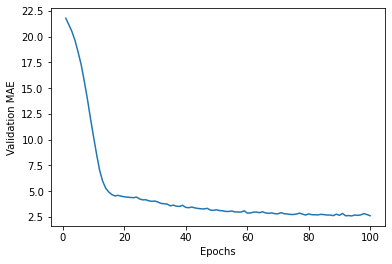

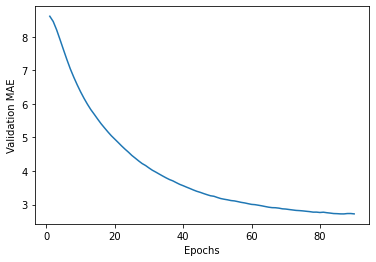

4/4 [==============================] - 0s 3ms/step - loss: 13.6596 - mae: 2.5291

 Test mae: 2.529146194458008


In [108]:
print('Validation mae:', validation_mae)

graph(num_epochs)

# test dataset
model.load_weights('./check.h5')
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('\n','Test mae:', test_mae_score)

## 4. Change Optimizer
- Hidden layer : 2
- Hidden units : 64-64-1
- Optimizer : ***adam***
- Loss : mse
- Metrics : mae
- Activation : tanh
- Learning rate : 0.001
- Epochs : ***100***
- Batch_size : ***20***
- K-fold validation : 4

####Result >   Test mae: 2.787949800491333

In [ ]:
all_mae_histories = []
num_epochs = 100
batch_size = 20

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model


num_val_samples = len(train_data) // 4
all_scores = []

cp = ModelCheckpoint(filepath='./check.h5',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

for i in range(4):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), callbacks=[cp], epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

validation_mae = np.mean(all_mae_histories)
validation_mae

Validation mae: 3.36762374907732


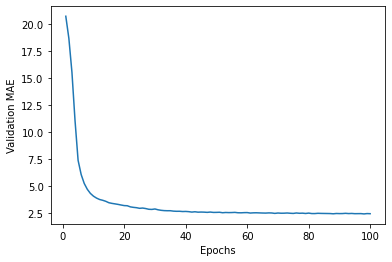

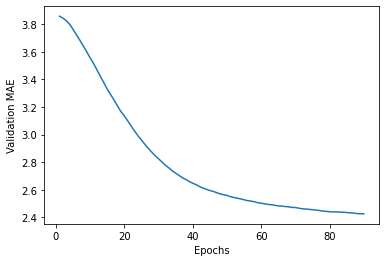

4/4 [==============================] - 0s 2ms/step - loss: 19.5530 - mae: 2.7879

 Test mae: 2.787949800491333


In [111]:
print('Validation mae:', validation_mae)

graph(num_epochs)

# test dataset
model.load_weights('./check.h5')
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('\n','Test mae:', test_mae_score)